In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Keras y modelos preentrenados
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, DenseNet121, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Para similitud y métricas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score

import zipfile
import pickle

# 1. LECTURA DE LA BASE Y DIVISIÓN TRAIN/TEST

In [ ]:
# Rutas de archivos y carpeta de imágenes
csv_path = "ruta/al/archivo/styles.csv"   # Ajusta la ruta
images_folder = "/content/drive/MyDrive/dataBasesPython/fashion_dataset/images/"

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/dataBasesPython/"
zip_path = '/content/drive/My Drive/dataBasesPython/images.csv.zip'
extract_path = '/content/extracted_files'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

csv_path = '/content/extracted_files/images.csv'
image = pd.read_csv(csv_path)

zip_path = '/content/drive/My Drive/dataBasesPython/styles.csv.zip'
extract_path = '/content/extracted_files'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

csv_path = '/content/extracted_files/styles.csv'
styles_original = pd.read_csv(csv_path, on_bad_lines='skip')
# Visualizar distribución de articleType

styles_original_clean = styles_original.dropna()
styles = styles_original_clean.sample(frac=0.10, random_state=42)  # frac=0.01 selecciona el 1%

print(f"Tamaño de la muestra: {styles.shape}")

categoryData = styles[['id', 'articleType']].dropna()
categoryData = categoryData.groupby(['articleType'], sort=True).size().reset_index(name='Count')
print("Total image categories:", len(categoryData))
print("\nNumber of Images in different classes\n", categoryData["Count"].describe())

Mounted at /content/drive
 fashion_dataset  'ratings_Electronics (1).csv.zip'   valencia_pollution_dataset.csv
 images.csv.zip    styles.csv.zip
Tamaño de la muestra: (4408, 10)
Total image categories: 117

Number of Images in different classes
 count    117.000000
mean      37.675214
std       83.841993
min        1.000000
25%        2.000000
50%        8.000000
75%       31.000000
max      695.000000
Name: Count, dtype: float64


# 1.1 Entendimiento de datos

In [ ]:
styles_original

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44419  17036    Men       Footwear       Shoes           Casual Shoes   
44420   6461    Men       Footwear  Flip Flops             Flip Flops   
44421  18842    Men        Apparel     Topwear                Tshirts   
44422  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44423  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44419      White  Summer  2013.0  Casual   
44420        Red  Summer  2011.0  Casual   
44421       Blue    Fall  2011.0  Casual   
44422       Blue  Spring  2017.0  Casual   
44423       Pink  Winter  2016.0  Casual   

                                    productDisplayName  
0                     Turtle Check Men Navy Blue Shirt  
1                   Peter England Men Party Blue Jeans  
2                             Titan Women Silver Watch  
3        Manchester United Men Solid Black Track Pants  
4                                Puma Men Grey T-shirt  
...                                                ...  
44419                        Gas Men Caddy Casual Shoe  
44420               Lotto Men's Soccer Track Flip Flop  
44421             Puma Men Graphic Stellar Blue Tshirt  
44422                   Rasasi Women Blue Lady Perfume  
44423  Fossil Women Pink Dial Chronograph Watch ES3050  

[44424 rows x 10 columns]

In [ ]:
print("Primeras filas de la base de datos:")
print(styles_original.head())

Primeras filas de la base de datos:
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


# Comparamos composición base original vs MAS

In [ ]:
style_masterCategory_dist = styles['masterCategory'].value_counts(normalize=True).reset_index()
style_masterCategory_dist.columns = ['masterCategory', 'Proporción en style']

style_original_masterCategory_dist = styles_original_clean['masterCategory'].value_counts(normalize=True).reset_index()
style_original_masterCategory_dist.columns = ['masterCategory', 'Proporción en style_original']

# Combinar ambas tablas para la comparación
comparison_table = pd.merge(style_masterCategory_dist, style_original_masterCategory_dist, on='masterCategory', how='outer')

comparison_table = pd.merge(style_masterCategory_dist, style_original_masterCategory_dist, on='masterCategory', how='outer')
display(comparison_table)

masterCategory  Proporción en style  Proporción en style_original
0     Accessories             0.253176                      0.255099
1         Apparel             0.485254                      0.484743
2        Footwear             0.209846                      0.208658
3      Free Items             0.002042                      0.002382
4            Home                  NaN                      0.000023
5   Personal Care             0.049456                      0.048529
6  Sporting Goods             0.000227                      0.000567

<ipython-input-6-76b6340116d8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles, x='masterCategory', palette='viridis')
<ipython-input-6-76b6340116d8>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original_clean, x='masterCategory', palette='viridis')


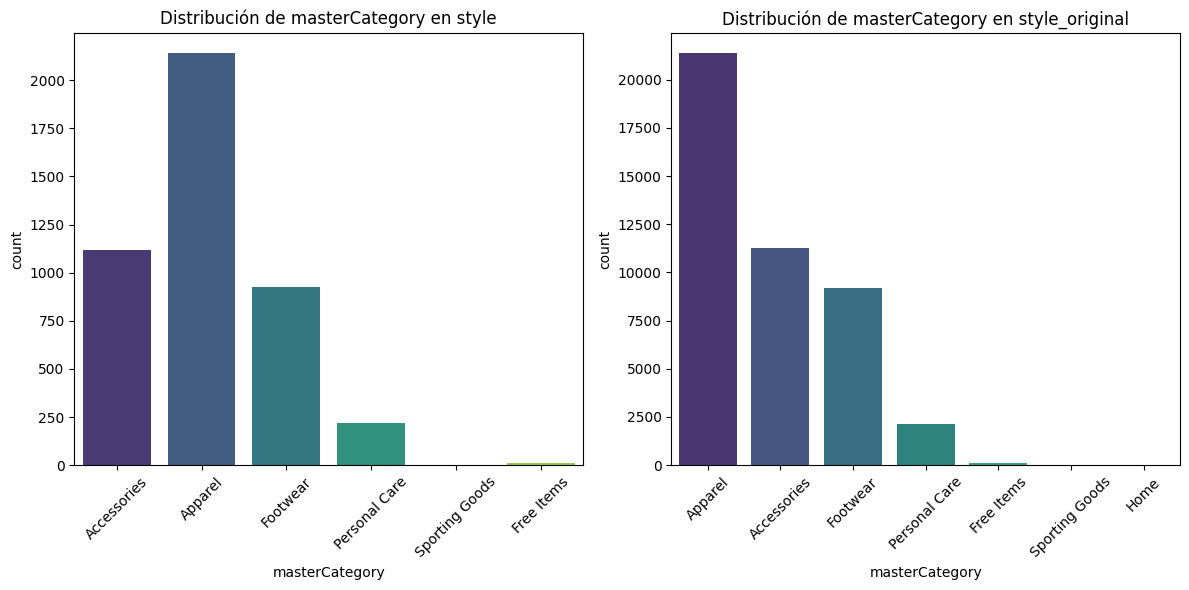

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=styles, x='masterCategory', palette='viridis')
plt.title('Distribución de masterCategory en style')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(data=styles_original_clean, x='masterCategory', palette='viridis')
plt.title('Distribución de masterCategory en style_original')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Descripción general de la base de datos
print("\nDescripción general de la base de datos:")
print(styles_original.describe(include='all'))


Descripción general de la base de datos:
                  id gender masterCategory subCategory articleType baseColour  \
count   44424.000000  44424          44424       44424       44424      44409   
unique           NaN      5              7          45         143         46   
top              NaN    Men        Apparel     Topwear     Tshirts      Black   
freq             NaN  22147          21397       15402        7067       9728   
mean    29696.334301    NaN            NaN         NaN         NaN        NaN   
std     17049.490518    NaN            NaN         NaN         NaN        NaN   
min      1163.000000    NaN            NaN         NaN         NaN        NaN   
25%     14768.750000    NaN            NaN         NaN         NaN        NaN   
50%     28618.500000    NaN            NaN         NaN         NaN        NaN   
75%     44683.250000    NaN            NaN         NaN         NaN        NaN   
max     60000.000000    NaN            NaN         NaN         NaN 

In [ ]:
# Tipos de datos de cada columna
print("\nTipos de datos de cada columna:")
print(styles_original.dtypes)


Tipos de datos de cada columna:
id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
dtype: object


In [ ]:
# Verificación de valores nulos por columna
print("\nValores nulos por columna:")
print(styles_original.isnull().sum())


Valores nulos por columna:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


<ipython-input-10-3abcd596dc33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original, x=col, palette='viridis')


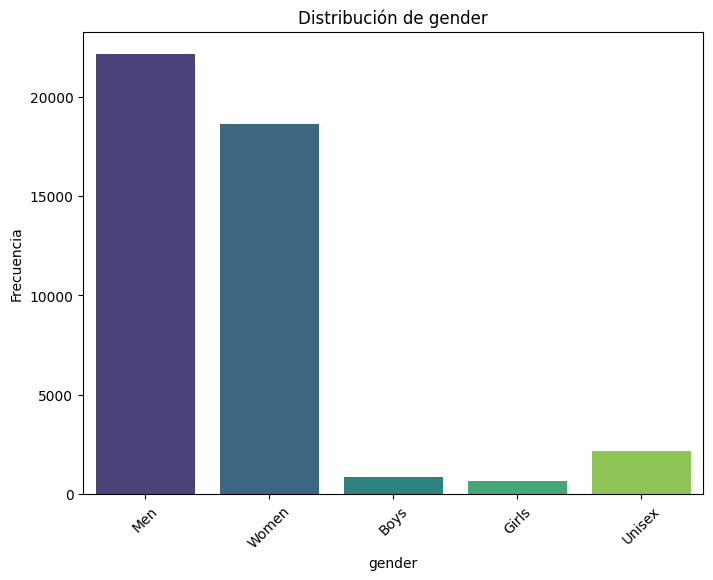

<ipython-input-10-3abcd596dc33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original, x=col, palette='viridis')


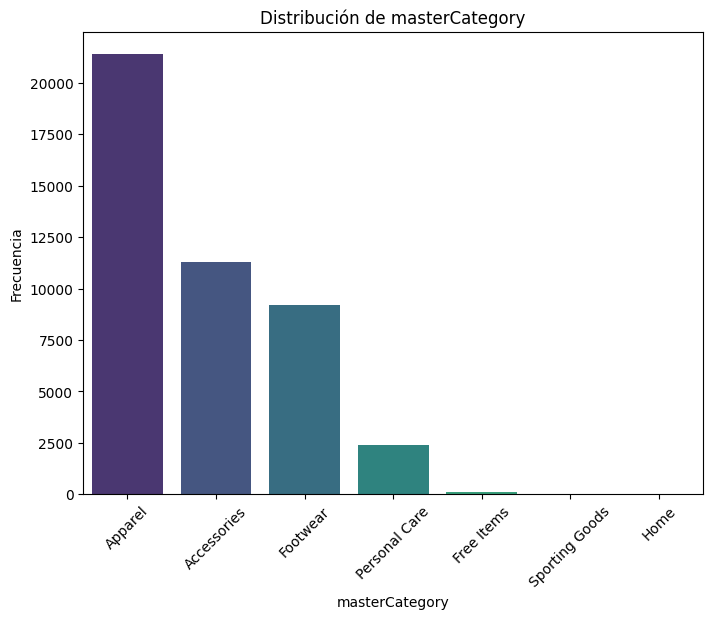

<ipython-input-10-3abcd596dc33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original, x=col, palette='viridis')


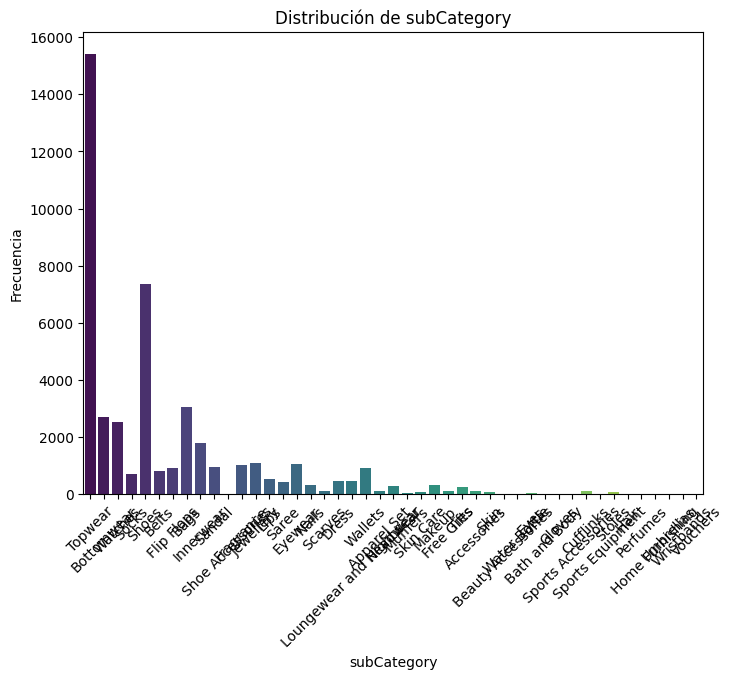

<ipython-input-10-3abcd596dc33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original, x=col, palette='viridis')


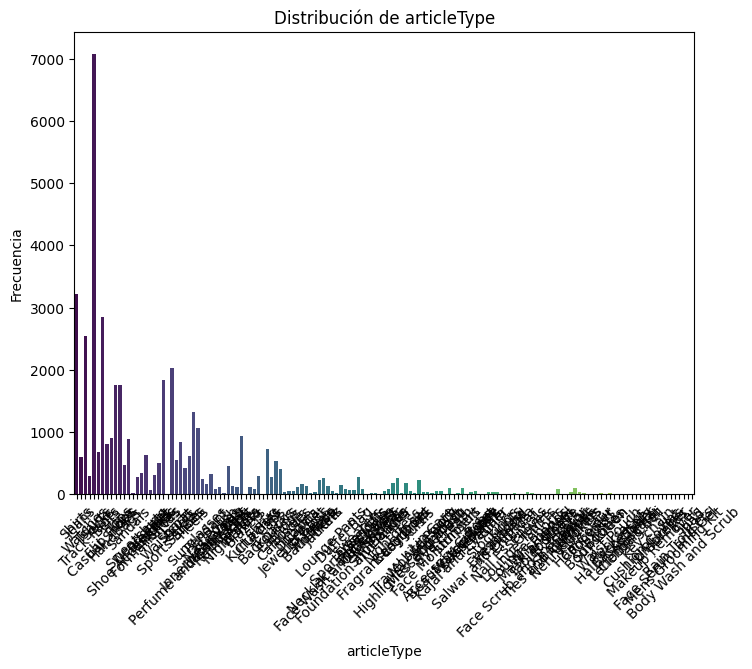

<ipython-input-10-3abcd596dc33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original, x=col, palette='viridis')


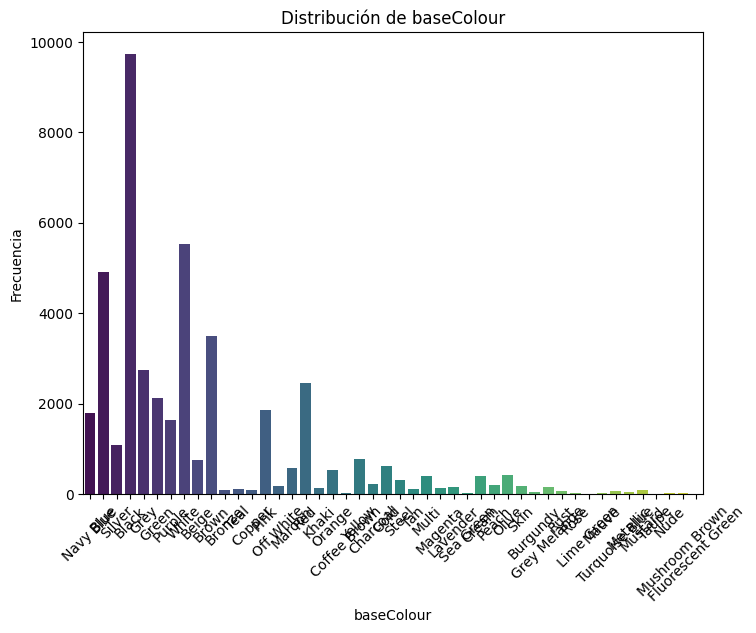

<ipython-input-10-3abcd596dc33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original, x=col, palette='viridis')


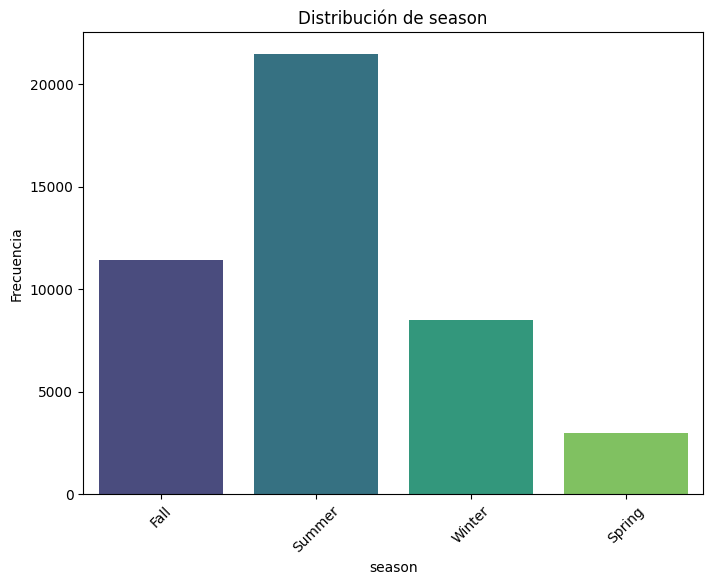

<ipython-input-10-3abcd596dc33>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=styles_original, x=col, palette='viridis')


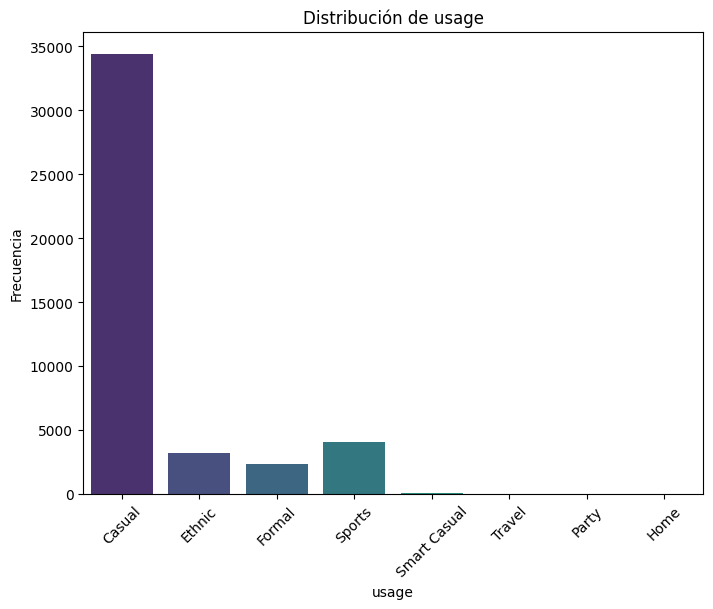

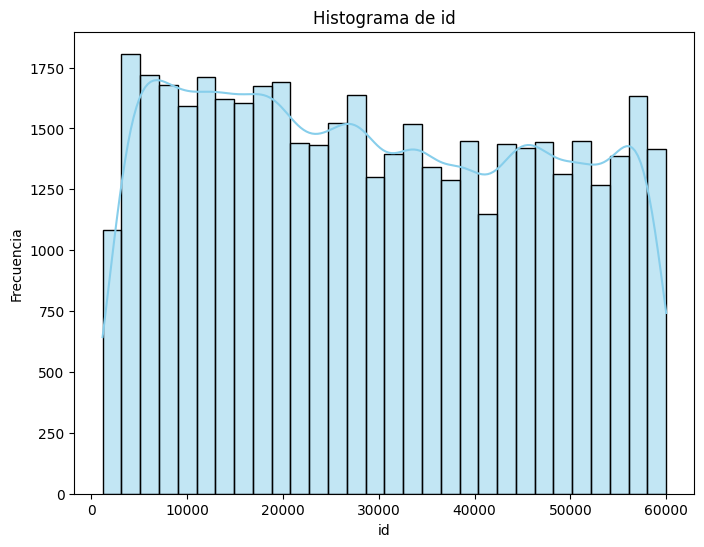

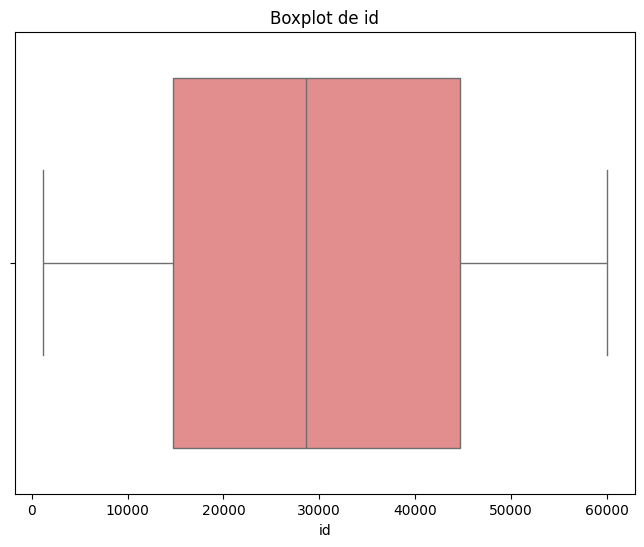

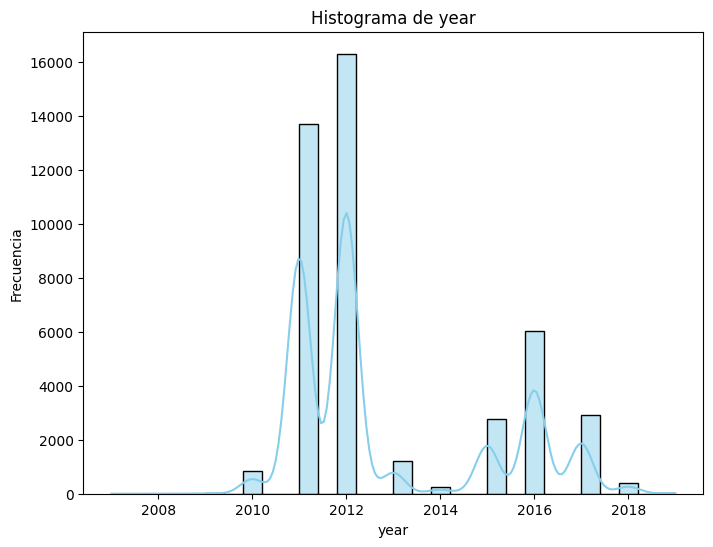

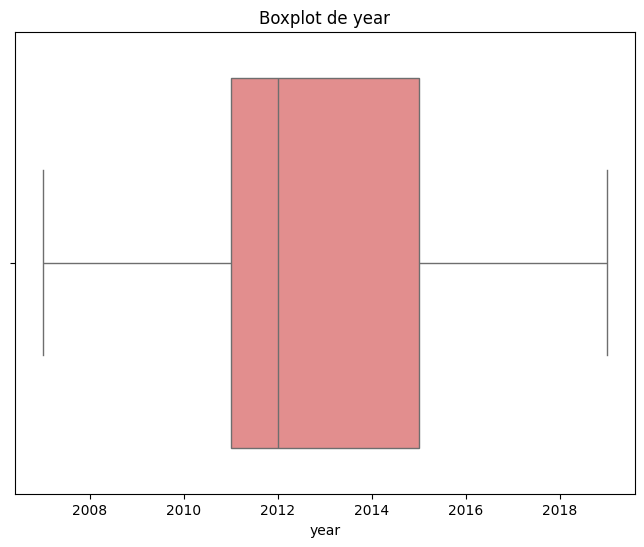

In [ ]:
# Crea un gráfico para cada columna categórica
categorical_columns = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=styles_original, x=col, palette='viridis')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

# Crea un gráfico para las columnas numéricas (histograma y boxplot)
numeric_columns = styles_original.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    # Histograma
    plt.figure(figsize=(8, 6))
    sns.histplot(styles_original[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

    # Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=styles_original[col], color='lightcoral')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()

In [ ]:
# Análisis de la variable 'year' para verificar el rango temporal
print("\nRango temporal de los datos (año):")
print(f"Año mínimo: {styles_original['year'].min()}")
print(f"Año máximo: {styles_original['year'].max()}")


Rango temporal de los datos (año):
Año mínimo: 2007.0
Año máximo: 2019.0


# 2. Preprocesamiento de imagenes

In [ ]:
def preprocesar_imagen(img_path, target_size=(224,224)):
    """
    Carga la imagen, la redimensiona y la normaliza a [0,1].
    """
    try:
        img = keras_image.load_img(img_path, target_size=target_size)
    except Exception as e:
        print(f"Error al cargar la imagen {img_path}: {e}")
        return None
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

def data_augmentation_demo(img_array, num_augmented=5):
    """
    Aplica data augmentation a una imagen (en formato array) y muestra ejemplos.
    Retorna una lista con las imágenes aumentadas.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    img_array_expanded = np.expand_dims(img_array, 0)
    augmented_images = []
    for batch in datagen.flow(img_array_expanded, batch_size=1):
        augmented_images.append(batch[0])
        if len(augmented_images) >= num_augmented:
            break

    plt.figure(figsize=(15,3))
    for i, aug_img in enumerate(augmented_images):
        plt.subplot(1, num_augmented, i+1)
        plt.imshow(np.clip(aug_img, 0, 1))
        plt.axis('off')
    plt.suptitle("Ejemplos de Data Augmentation")
    plt.show()

    return augmented_images

Error al cargar la imagen /content/drive/MyDrive/dataBasesPython/fashion_dataset/images/37871.jpg: [Errno 5] Input/output error: '/content/drive/MyDrive/dataBasesPython/fashion_dataset/images/37871.jpg'


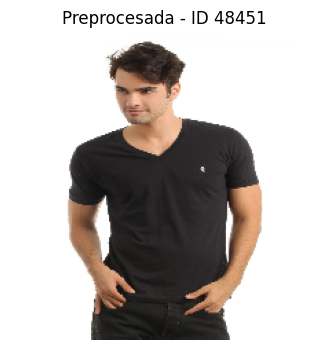

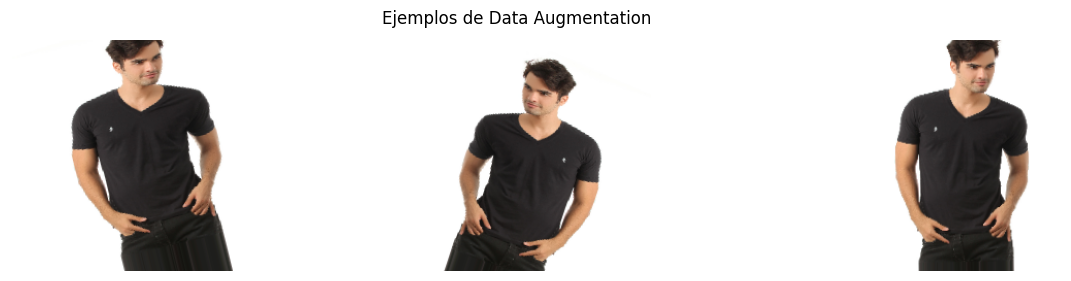

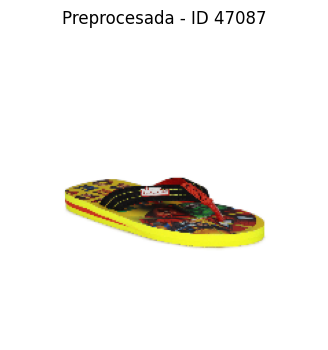

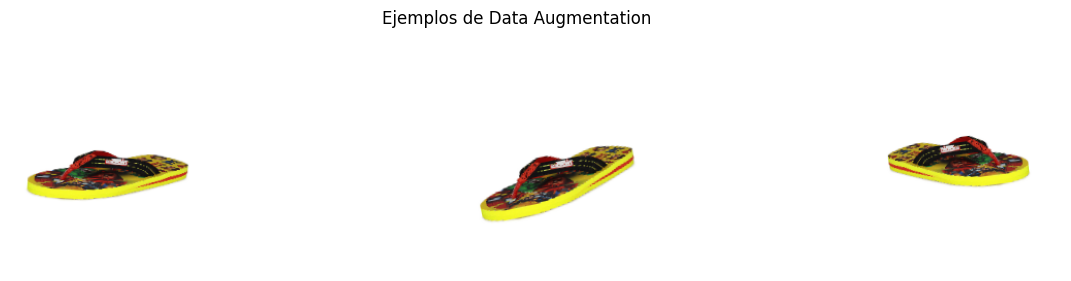

Total image categories: 117

Number of Images in different classes
 count    117.000000
mean      37.675214
std       83.841993
min        1.000000
25%        2.000000
50%        8.000000
75%       31.000000
max      695.000000
Name: Count, dtype: float64


In [ ]:
# Definir la carpeta de imágenes (ajusta la ruta según corresponda)
images_folder = "/content/drive/MyDrive/dataBasesPython/fashion_dataset/images/"

# Seleccionamos algunos IDs del DataFrame 'styles' para visualizar ejemplos
sample_ids = styles['id'].head(3).tolist()
for img_id in sample_ids:
    img_path = os.path.join(images_folder, f"{img_id}.jpg")
    img_proc = preprocesar_imagen(img_path, target_size=(224,224))
    if img_proc is not None:
        plt.figure(figsize=(4,4))
        plt.imshow(img_proc)
        plt.title(f"Preprocesada - ID {img_id}")
        plt.axis('off')
        plt.show()
        # Mostrar ejemplos de data augmentation
        data_augmentation_demo(img_proc, num_augmented=3)

# ==============================
# Análisis de la distribución de 'articleType'
# ==============================

categoryData = styles[['id', 'articleType']].dropna()
categoryData = categoryData.groupby(['articleType'], sort=True).size().reset_index(name='Count')
print("Total image categories:", len(categoryData))
print("\nNumber of Images in different classes\n", categoryData["Count"].describe())

In [ ]:
def trainTestSplit(styles_df):
    trainData = []
    testData = []
    for category in styles_df["articleType"].unique():
        data = styles_df.loc[styles_df["articleType"] == category]
        count = len(data)
        trainCount = int(0.8 * count)
        trainData.append(data.iloc[:trainCount])
        testData.append(data.iloc[trainCount:])
    trainData = pd.concat(trainData, ignore_index=True)
    testData = pd.concat(testData, ignore_index=True)
    return trainData, testData

trainData, testData = trainTestSplit(styles)
print("Training set shape:", trainData.shape)
print("Testing set shape:", testData.shape)

Training set shape: (3476, 10)
Testing set shape: (932, 10)


# 2. DEFINICIÓN DE FUNCIONES DE EXTRACCIÓN

In [ ]:
# (A) Métodos Handcrafted
# Baseline: Histograma de color en espacio HSV
def extraer_feature_baseline(img_path, target_size=(224,224)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, target_size)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Se calculan histogramas para cada canal (8 bins cada uno)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    hist = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    hist = hist / np.sum(hist)  # Normalizar
    return hist

# CCBR: Combina histograma de color (como baseline) con un histograma de bordes
def extraer_feature_CCBR(img_path, target_size=(224,224)):
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.resize(img, target_size)
    # Histograma de color
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [8], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [8], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [8], [0, 256])
    hist_color = np.concatenate([hist_h, hist_s, hist_v]).flatten()
    hist_color = hist_color / np.sum(hist_color)
    # Histograma de bordes: usando Laplacian
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Laplacian(gray, cv2.CV_64F)
    hist_edges = cv2.calcHist([edges.astype('uint8')], [0], None, [8], [0, 256])
    hist_edges = hist_edges.flatten()
    hist_edges = hist_edges / np.sum(hist_edges)
    # Concatenar ambos
    return np.concatenate([hist_color, hist_edges])

# (B) Método Deep Learning: función genérica de extracción
def extraer_feature_dl(img_path, model, preprocess_func, target_size):
    try:
        img = keras_image.load_img(img_path, target_size=target_size)
    except Exception as e:
        print(f"Error al cargar {img_path}: {e}")
        return None
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)
    features = model.predict(img_array)
    return features.flatten()


# Función que actúa según el método (handcrafted o DL)
def get_features(model_name, img_path, models_config):
    config = models_config[model_name]
    if config['type'] == 'handcrafted':
        return config['func'](img_path, config['target_size'])
    else:
        return extraer_feature_dl(img_path, config['model'], config['preprocess'], config['target_size'])

# 3. CONFIGURACIÓN DE LOS DIFERENTES MODELOS

In [ ]:
# Se define un diccionario de configuraciones para cada método.
models_config = {
    'Baseline': {
        'type': 'handcrafted',
        'func': extraer_feature_baseline,
        'target_size': (224,224)
    },
    'CCBR': {
        'type': 'handcrafted',
        'func': extraer_feature_CCBR,
        'target_size': (224,224)
    },
    'VGG16': {
        'type': 'dl',
        'model': VGG16(weights='imagenet', include_top=False, pooling='avg'),
        'preprocess': vgg_preprocess,
        'target_size': (224,224)
    },
    'ResNet50': {
        'type': 'dl',
        'model': ResNet50(weights='imagenet', include_top=False, pooling='avg'),
        'preprocess': resnet_preprocess,
        'target_size': (224,224)
    },
    'MobileNetV2': {
        'type': 'dl',
        'model': MobileNetV2(weights='imagenet', include_top=False, pooling='avg'),
        'preprocess': mobilenet_preprocess,
        'target_size': (224,224)
    },
    'DenseNet121': {
        'type': 'dl',
        'model': DenseNet121(weights='imagenet', include_top=False, pooling='avg'),
        'preprocess': densenet_preprocess,
        'target_size': (224,224)
    },
    'InceptionV3': {
        'type': 'dl',
        'model': InceptionV3(weights='imagenet', include_top=False, pooling='avg'),
        'preprocess': inception_preprocess,
        'target_size': (299,299)
    }
}

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


<ipython-input-20-932e82c7e0b0>:27: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  'model': MobileNetV2(weights='imagenet', include_top=False, pooling='avg'),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# 4. CONSTRUCCIÓN DE MATRICES DE FEATURES

In [ ]:
# Solo para pruebas
!rm "/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_train.pkl"
!rm "/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_test.pkl"

rm: cannot remove '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_train.pkl': No such file or directory
rm: cannot remove '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_test.pkl': No such file or directory


In [ ]:
# Definir las rutas donde se guardarán las features
features_train_path = '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_train.pkl'
features_test_path  = '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_test.pkl'

if os.path.exists(features_train_path) and os.path.exists(features_test_path):
    with open(features_train_path, 'rb') as f:
        features_train = pickle.load(f)
    with open(features_test_path, 'rb') as f:
        features_test = pickle.load(f)
    print("Features cargadas desde disco.")
else:
    print("No se encontraron archivos de features. Extrayendo y guardando features...")
    features_train = {}
    features_test = {}

No se encontraron archivos de features. Extrayendo y guardando features...


In [ ]:
def build_features_for_model(data, model_name, models_config, images_folder):
    features = []
    ids = []
    for idx in data.index:
        img_id = data.loc[idx, 'id']
        img_path = os.path.join(images_folder, str(img_id) + ".jpg")
        feature_vector = get_features(model_name, img_path, models_config)
        if feature_vector is not None:
            features.append(feature_vector)
            ids.append(img_id)
        else:
            print(f"Error al extraer características de la imagen {img_id}")

    features_matrix = np.array(features)
    return features_matrix, ids

In [ ]:
features_train_path = '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_train.pkl'
features_test_path  = '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_test.pkl'

if os.path.exists(features_train_path) and os.path.exists(features_test_path):
    print("Los archivos de features ya existen.")
else:
    print("No se encontraron archivos de features. Extrayendo y guardando features...")
    features_train = {}
    features_test = {}

    # Extraer features para TRAIN (asegúrate de que 'trainData', 'models_config' y 'images_folder' estén definidos)
    for model_name in models_config.keys():
        print(f"Procesando {model_name} en TRAIN...")
        feat_mat, _ = build_features_for_model(trainData, model_name, models_config, images_folder)
        features_train[model_name] = feat_mat

    # Extraer features para TEST
    for model_name in models_config.keys():
        print(f"Procesando {model_name} en TEST...")
        feat_mat, _ = build_features_for_model(testData, model_name, models_config, images_folder)
        features_test[model_name] = feat_mat

    # Asegurarse de que la carpeta destino existe
    save_folder = '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo'
    os.makedirs(save_folder, exist_ok=True)

    # Guardar los diccionarios de features en disco
    with open(features_train_path, 'wb') as f:
        pickle.dump(features_train, f)
    with open(features_test_path, 'wb') as f:
        pickle.dump(features_test, f)

    print("Features extraídas y guardadas en disco.")

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1

Features cargadas desde disco.

Resultados promedio por modelo:
             Precision  Recall
Baseline         0.240    0.64
CCBR             0.408    0.72
VGG16            0.836    0.98
ResNet50         0.836    0.98
MobileNetV2      0.876    0.98
DenseNet121      0.844    0.98
InceptionV3      0.864    1.00


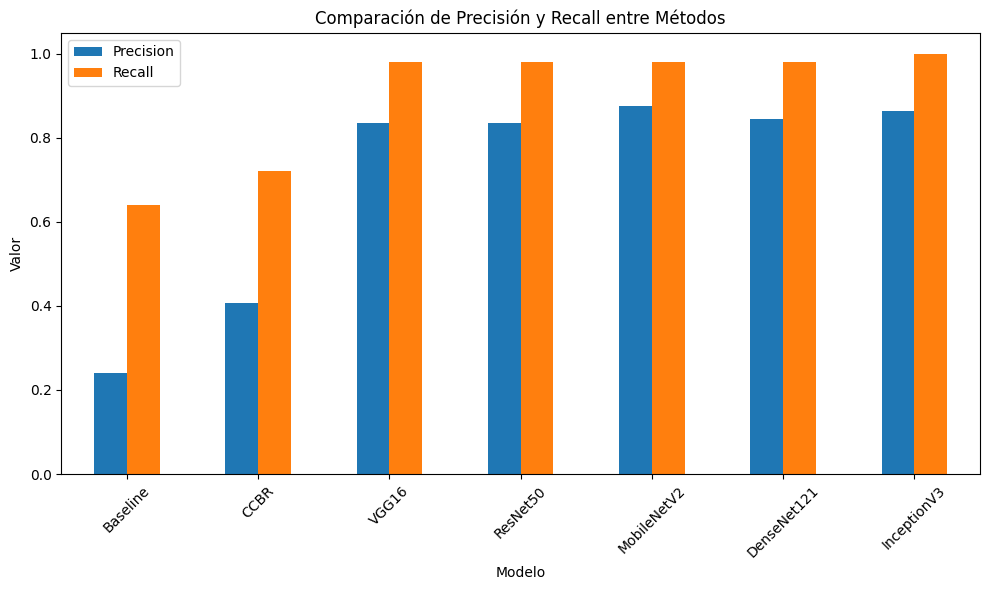

In [ ]:
# Rutas de los archivos guardados
features_train_path = '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_train.pkl'
features_test_path  = '/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/Segunda_Convo/features_test.pkl'

# Cargar las matrices de features guardadas
with open(features_train_path, 'rb') as f:
    features_train = pickle.load(f)
with open(features_test_path, 'rb') as f:
    features_test = pickle.load(f)
print("Features cargadas desde disco.")

# Función para recomendar usando similitud coseno
def recomendar(query_feature, features_matrix, top_k=5):
    sims = cosine_similarity([query_feature], features_matrix)[0]
    indices_recomendados = np.argsort(sims)[::-1][:top_k]
    return indices_recomendados, sims[indices_recomendados]

# Evaluación: Para cada imagen de test, se buscan los top_k vecinos en el conjunto de train
top_k = 5
resultados = {}

# Por ejemplo, evaluamos hasta 50 consultas de test (o menos, según disponibilidad)
n_consultas = min(50, len(testData))

for model_name in models_config.keys():
    precision_scores = []
    recall_scores = []
    feat_test = features_test[model_name]
    feat_train = features_train[model_name]

    for i in range(n_consultas):
        query_feature = feat_test[i]
        indices_recomendados, sims = recomendar(query_feature, feat_train, top_k=top_k)
        # Obtenemos la categoría de la imagen de test
        query_category = testData.iloc[i]['articleType']
        # Comparar la categoría de la imagen de test con la de cada imagen recomendada del conjunto train
        y_true = []
        for idx in indices_recomendados:
            train_category = trainData.iloc[idx]['articleType']
            y_true.append(1 if train_category == query_category else 0)
        # Como se supone que todas las recomendaciones se "predicen" como relevantes, se asume y_pred = [1,...,1]
        y_pred = [1] * len(y_true)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        precision_scores.append(prec)
        recall_scores.append(rec)

    resultados[model_name] = {
        'Precision': np.mean(precision_scores),
        'Recall': np.mean(recall_scores)
    }

# Convertir los resultados a un DataFrame para visualización
resultados_df = pd.DataFrame(resultados).T
print("\nResultados promedio por modelo:")
print(resultados_df)

# Gráfico comparativo de precisión y recall
resultados_df[['Precision', 'Recall']].plot(kind='bar', figsize=(10,6))
plt.title("Comparación de Precisión y Recall entre Métodos")
plt.xlabel("Modelo")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Visualización de Resultados

In [ ]:
best_model = resultados_df['Precision'].idxmax()
print("Modelo con mayor precisión:", best_model)

Modelo con mayor precisión: MobileNetV2


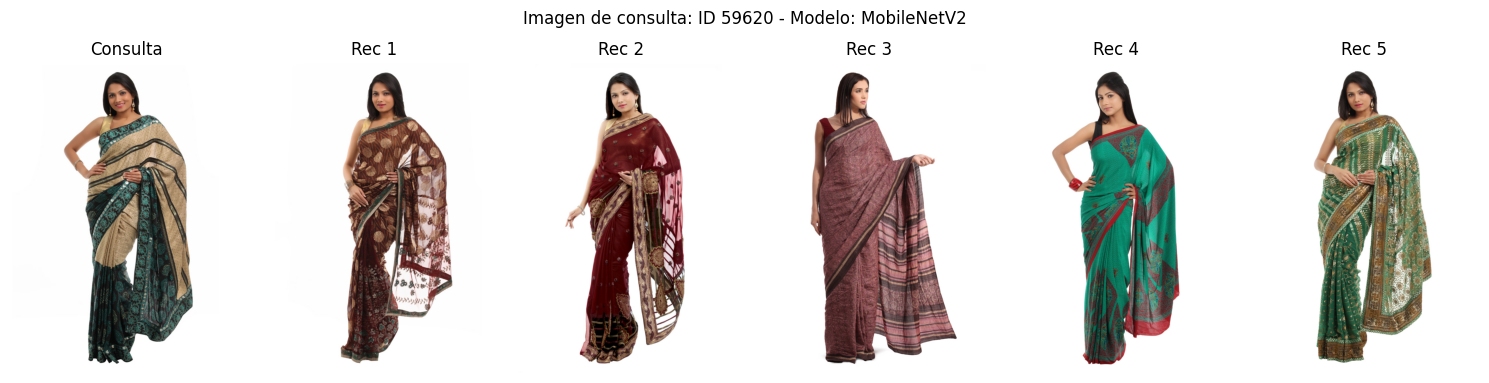

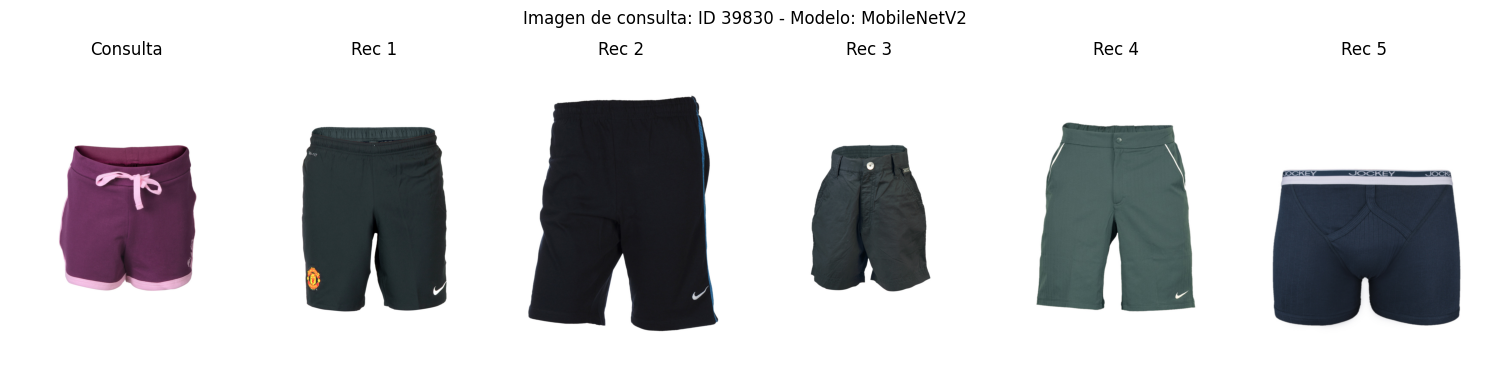

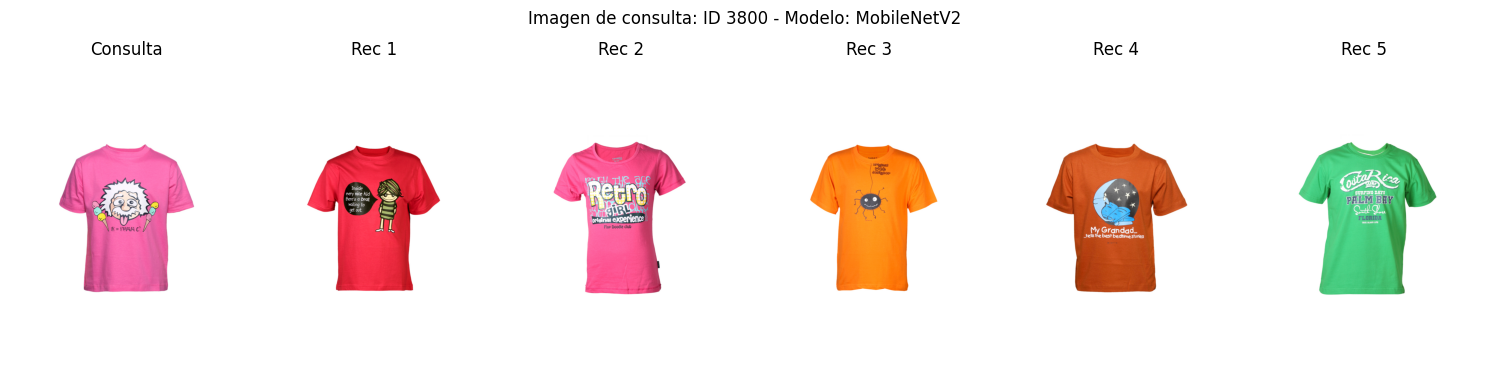

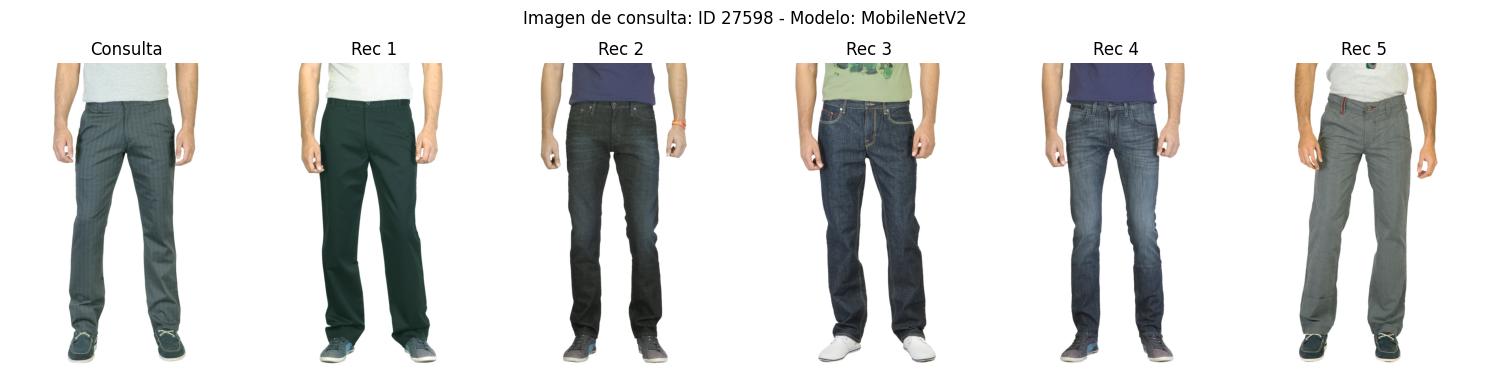

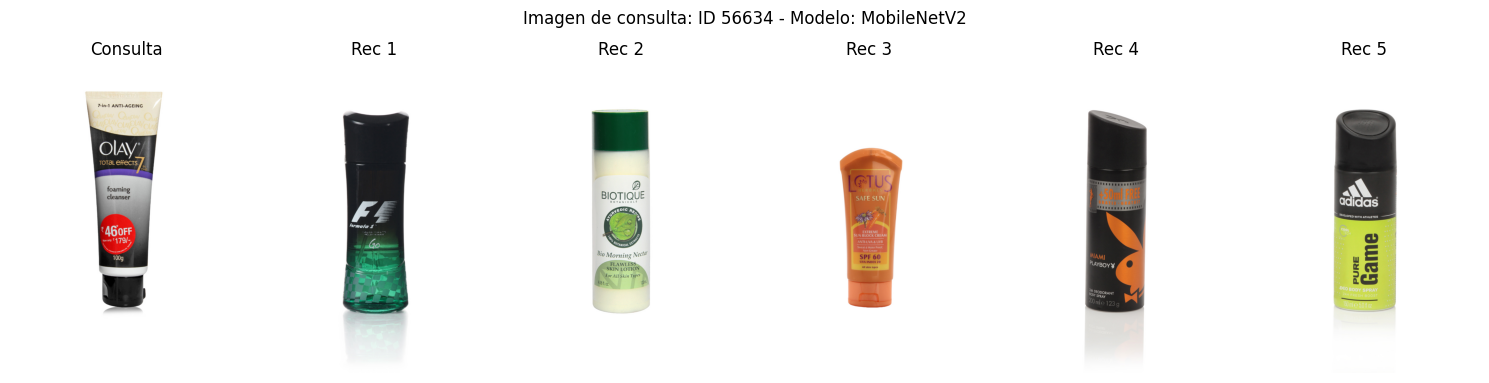

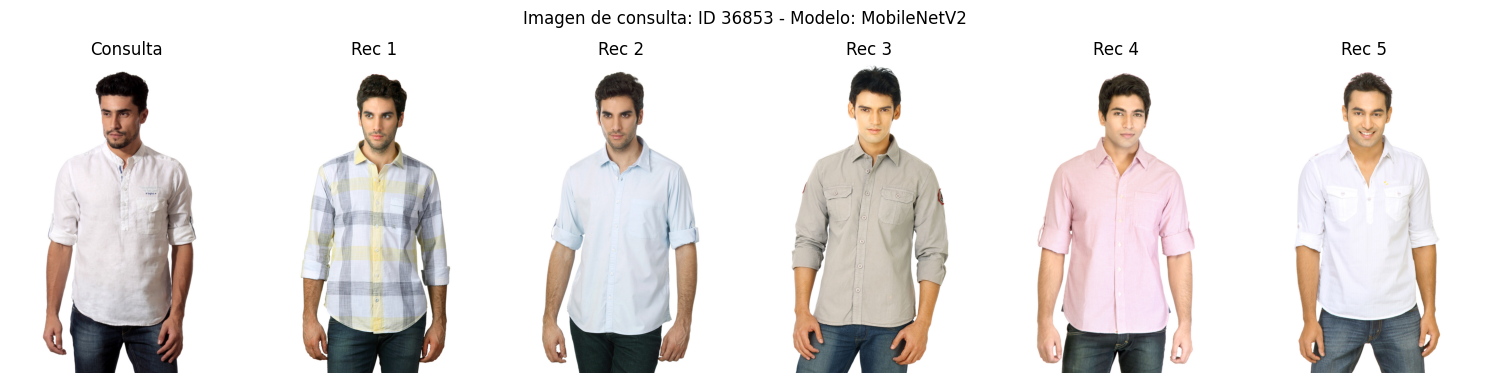

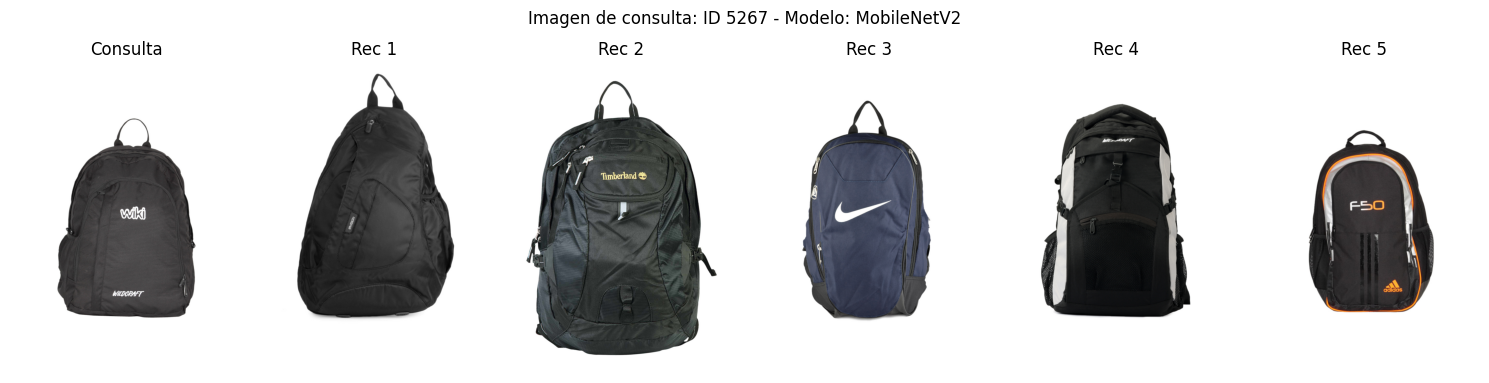

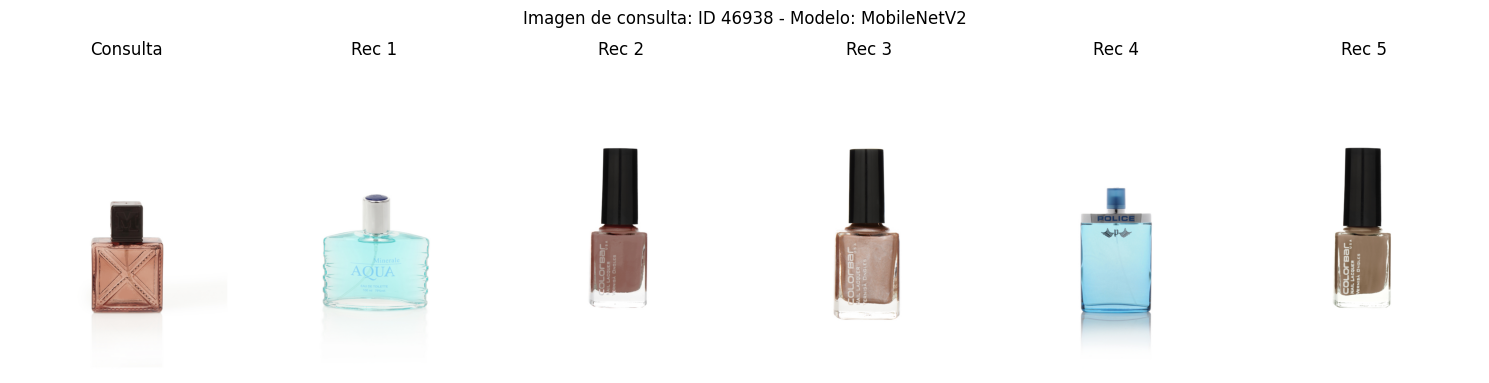

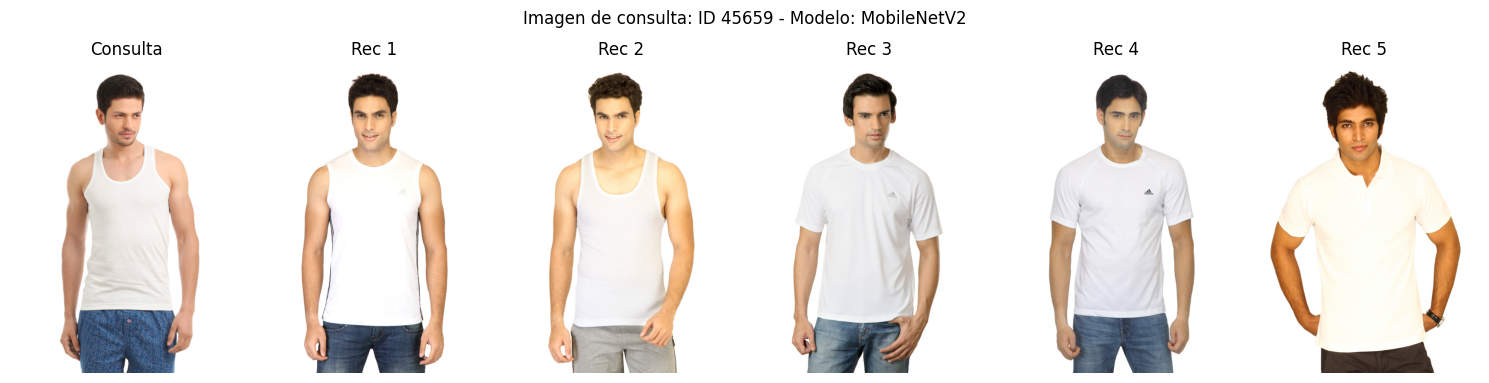

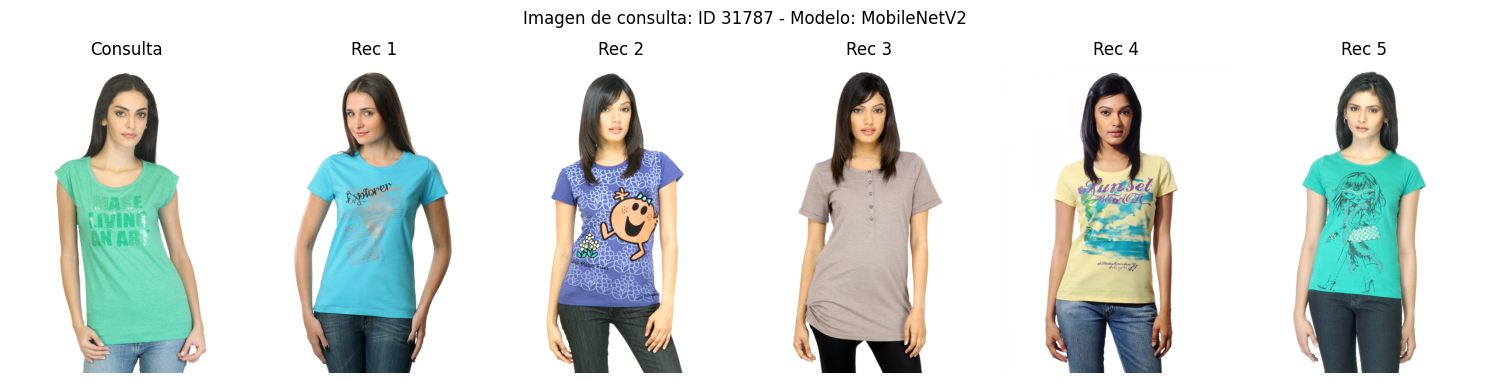

In [ ]:
# Número de vecinos recomendados a mostrar (por ejemplo, top 5)
top_k = 5

# Seleccionar 10 índices de imágenes de test de forma aleatoria
num_consultas = 10
random_indices = np.random.choice(range(len(testData)), size=num_consultas, replace=False)

for idx in random_indices:
    # Obtener la imagen de consulta del conjunto de test
    test_img_id = testData.iloc[idx]['id']
    test_img_path = os.path.join(images_folder, f"{test_img_id}.jpg")
    test_img = cv2.imread(test_img_path)
    if test_img is None:
        print(f"No se pudo cargar la imagen {test_img_path}")
        continue
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    # Extraer la feature de la imagen de consulta usando el mejor modelo
    query_feature = features_test[best_model][idx]

    # Buscar las recomendaciones (índices) en el conjunto de entrenamiento
    recommended_indices, sims = recomendar(query_feature, features_train[best_model], top_k=top_k)

    # Configurar figura para visualizar: imagen de consulta + top_k imágenes recomendadas
    plt.figure(figsize=(15,4))
    # Mostrar imagen de consulta
    plt.subplot(1, top_k+1, 1)
    plt.imshow(test_img_rgb)
    plt.title("Consulta")
    plt.axis('off')

    # Mostrar las imágenes recomendadas
    for j, rec_idx in enumerate(recommended_indices):
        train_img_id = trainData.iloc[rec_idx]['id']
        train_img_path = os.path.join(images_folder, f"{train_img_id}.jpg")
        train_img = cv2.imread(train_img_path)
        if train_img is not None:
            train_img_rgb = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, top_k+1, j+2)
            plt.imshow(train_img_rgb)
            plt.title(f"Rec {j+1}")
            plt.axis('off')
        else:
            plt.subplot(1, top_k+1, j+2)
            plt.text(0.5, 0.5, "No Image", horizontalalignment='center', verticalalignment='center')
            plt.axis('off')

    plt.suptitle(f"Imagen de consulta: ID {test_img_id} - Modelo: {best_model}")
    plt.tight_layout()
    plt.show()